## Import

In [2]:
from ipywidgets import *
from scipy.stats import zscore, spearmanr
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

np.set_printoptions(suppress=True)

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = True

## Load data

In [3]:
FIR_tot_novelty_ev = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_novelty_ev.npy')
FIR_tot_memory_ev = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_memory_ev.npy')
FIR_tot_recall_ev = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_recall_start_ev.npy')

novelty_co_space_novelty_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_novelty_true.npy')
novelty_co_space_novelty_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_novelty_perm.npy')
novelty_val_space_novelty_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_novelty_true.npy')
novelty_val_space_novelty_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_novelty_perm.npy')

novelty_co_space_memory_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_memory_true.npy')
novelty_co_space_memory_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_memory_perm.npy')
novelty_val_space_memory_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_memory_true.npy')
novelty_val_space_memory_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_memory_perm.npy')

memory_space_memory_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_memory_true.npy')
memory_space_memory_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_memory_perm.npy')
memory_space_novelty_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_novelty_true.npy')
memory_space_novelty_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_novelty_perm.npy')

recall_start_space_recall_true = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/retrieval_space_retrieval_true.npy')
recall_start_space_recall_perm = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/retrieval_space_retrieval_perm.npy')

## Calculating encoding performance

In [21]:
window_length = 21
repetition = 1000

def subspace_encoding_performance(true_data, perm_data, pc_num, model_data):
    true_est_pos = []
    r2_true = []
    for t in range(window_length):
        distance_mat = cdist(true_data[:,pc_num,t], true_data[:,pc_num,t])
        len_from_p1 = []
        for c in range(true_data.shape[0]):
            p1 = true_data[np.where(distance_mat == np.max(distance_mat))[0][1],pc_num,t]
            p2 = true_data[np.where(distance_mat == np.max(distance_mat))[0][0],pc_num,t] 
            p3 = true_data[c,pc_num,t] 

            unit_length = np.linalg.norm(p1-p2)
            l2 = np.sum((p1-p2)**2)
            a = np.sum((p3 - p1) * (p2 - p1)) / l2
            a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
            projection = p1 + a * (p2 - p1)
            len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
        r2_true.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)
        true_est_pos.append(len_from_p1)

    r2_perm = []
    for repeat in range(len(perm_data)):
        r2 = []
        for t in range(window_length):
            distance_mat = cdist(perm_data[repeat][:,pc_num,t], perm_data[repeat][:,pc_num,t])  
            len_from_p1 = []
            for c in range(true_data.shape[0]):
                p1 = perm_data[repeat][np.where(distance_mat == np.max(distance_mat))[0][1],pc_num,t]
                p2 = perm_data[repeat][np.where(distance_mat == np.max(distance_mat))[0][0],pc_num,t] 
                p3 = perm_data[repeat][c,pc_num,t] 

                unit_length = np.linalg.norm(p1-p2)
                l2 = np.sum((p1-p2)**2)
                a = np.sum((p3 - p1) * (p2 - p1)) / l2
                a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
                projection = p1 + a * (p2 - p1)
                len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
            r2.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)
        r2_perm.append(r2)

    r2_true = np.array(r2_true)
    r2_perm = np.array(r2_perm)
    pvalue = [np.sum(r2_perm[:,t] > r2_true[t])/repetition for t in range(window_length)]
    return r2_true, r2_perm, pvalue

### Encoding performance within hippocampal subspaces (Fig. 3C)

In [22]:
roi_num = 0 # hippocampus

fMRI_data_true = novelty_co_space_novelty_true[roi_num] # observed subspace
fMRI_data_perm = novelty_co_space_novelty_perm[roi_num] # permuted subspaces
pc_num = np.arange(12) # 12 PCs
# pc_num = [0] # first PC
# pc_num = [1] # second PC
model_data = [-1,-1,-1,0,0,0,1,1,1] # co-occurrence novelty
r2_true_cooccur, r2_perm_cooccur, pvalue_cooccur = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                                                 perm_data = fMRI_data_perm, 
                                                                                 pc_num = pc_num, 
                                                                                 model_data = model_data)

fMRI_data_true = novelty_val_space_novelty_true[roi_num]
fMRI_data_perm = novelty_val_space_novelty_perm[roi_num]
pc_num = np.arange(12) # 12 PCs
model_data = [-1,0,1,-1,0,1,-1,0,1] # valence novelty
r2_true_valence, r2_perm_valence, pvalue_valence = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                                                 perm_data = fMRI_data_perm, 
                                                                                 pc_num = pc_num, 
                                                                                 model_data = model_data)

fMRI_data_true = memory_space_memory_true[roi_num]
fMRI_data_perm = memory_space_memory_perm[roi_num]
pc_num = np.arange(12) # 12 PCs
model_data = [-4,-3,-2,-1,0,1,2,3,4] # memorability
r2_true_memorability, r2_perm_memorability, pvalue_memorability = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                                                                perm_data = fMRI_data_perm, 
                                                                                                pc_num = pc_num, 
                                                                                                model_data = model_data)

#### Each time plot (Fig. 3C left)

In [ ]:
r2_true = r2_true_cooccur
r2_perm = r2_perm_cooccur

fig = plt.figure(figsize = [7,3])
axs = fig.add_subplot()

## observed encoding performance with a null distribution at each time point
# axs.plot(r2_true, 'r')
# axs.plot(np.mean(r2_perm, axis=0), 'grey')
# errorh = np.array([np.std(r2_perm[:,t])*2 for t in range(window_length)])
# axs.fill_between(np.arange(window_length), np.mean(r2_perm, axis=0)-errorh,np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')

## observed encoding performance - the null distribution at each time point
axs.plot(r2_true-np.mean(r2_perm, axis=0), 'r')
errorh = np.array([np.std(r2_true[t] - r2_perm[:,t])*2 for t in range(window_length)])
axs.fill_between(np.arange(window_length), r2_true-np.mean(r2_perm, axis=0)-errorh,r2_true-np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')

axs.set_ylim([-0.5,1])
axs.hlines(0, 0, window_length-1, linestyle = '--', color = 'grey')
axs.vlines(10, -1, 1, linestyle = '--', color = 'grey')
axs.set_xticks([0,5,10,15,20])
axs.set_yticks([-0.5,0,0.5,1])
axs.set_xticklabels(['','',0,'',''])

for t in range(21):
    if np.sum(r2_perm[:,t] > r2_true[t])/repetition < .05:
        plt.text(t-0.2,0.9,'*')

#### Average across 10 TRs (Fig. 3C right)

In [ ]:
before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T

plt.figure(figsize = [4,5])
bar1 = plt.bar([0], [np.mean(before)], color = 'navy', edgecolor = 'k', linewidth = 3, width = 0.7, alpha = 0.5) # #FF0000 #9C27B0 #656B83
plt.bar([1], [np.mean(after)], color = 'navy', edgecolor = 'k', linewidth = 3, width = 0.7) # #FF0000 #9C27B0 navy
# plt.errorbar([0,1], [np.mean(before), np.mean(after)], [np.std(before)*2, np.std(after)*2], linestyle = '', color = 'k', linewidth = 3)
plt.scatter(np.random.normal(size = 1000)/15, before, color = 'grey', alpha = 0.1)
plt.scatter(np.random.normal(size = 1000)/15 + 1 , after, color = 'grey', alpha = 0.1)
plt.xlim([-0.6, 1.6])
plt.ylim([0,0.8])
plt.xticks([0,1])
plt.yticks([0,0.4,0.8])

### Aligned novelty computation

#### Each time plot (Fig. 4C)

In [ ]:
## co-occurrence novelty within the valence novelty subspace
MRI_data_true = novelty_val_space_novelty_true[roi_num]
fMRI_data_perm = novelty_val_space_novelty_perm[roi_num]

pc_num = [0] # novelty coding axis
model_data = [-1,-1,-1,0,0,0,1,1,1] # co-occurrence novelty
r2_true, r2_perm, pvalue = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                         perm_data = fMRI_data_perm, 
                                                         pc_num = pc_num,
                                                         model_data = model_data)

fig = plt.figure(figsize = [7,3])
axs = fig.add_subplot()

axs.plot(r2_true-np.mean(r2_perm, axis=0), 'r')
errorh = np.array([np.std(r2_true[t] - r2_perm[:,t])*2 for t in range(window_length)])
axs.fill_between(np.arange(window_length), r2_true-np.mean(r2_perm, axis=0)-errorh,r2_true-np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')

axs.set_ylim([-0.5,1])
axs.hlines(0, 0, window_length-1, linestyle = '--', color = 'grey')
axs.vlines(10, -1, 1, linestyle = '--', color = 'grey')
axs.set_xticks([0,5,10,15,20])
axs.set_yticks([-0.5,0,0.5,1])
axs.set_xticklabels(['','',0,'',''])

for t in range(21):
    if np.sum(r2_perm[:,t] > r2_true[t])/repetition < .05:
        plt.text(t-0.2,0.9,'*')

#### Average across 10 TR (Fig. 4D, Supp Fig. 4)

In [54]:
## within co-occurrence novelty subspaces 
fMRI_data_true = novelty_co_space_novelty_true[roi_num] # observed subspace
fMRI_data_perm = novelty_co_space_novelty_perm[roi_num] # permuted subspaces

model_data = [-1,-1,-1,0,0,0,1,1,1] # co-occurrence novelty
before_co_space_co = []
after_co_space_co = []
for pc_num in range(12):
    r2_true, r2_perm, _ = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                     perm_data = fMRI_data_perm, 
                                                     pc_num = np.arange(pc_num+1), # Supp Fig.4AC / # of PCs
                                                    #  pc_num = [pc_num], # Supp Fig.4BD / each PC
                                                     model_data = model_data)
    before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
    after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T
    before_co_space_co.append(before)
    after_co_space_co.append(after)

model_data = [-1,0,1,-1,0,1,-1,0,1] # valence novelty
before_co_space_val = []
after_co_space_val = []
for pc_num in range(12):
    r2_true, r2_perm, _ = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                     perm_data = fMRI_data_perm, 
                                                     pc_num = np.arange(pc_num+1),
                                                    #  pc_num = [pc_num],
                                                     model_data = model_data)
    before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
    after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T
    before_co_space_val.append(before)
    after_co_space_val.append(after)

## within valence novelty subspaces
fMRI_data_true = novelty_val_space_novelty_true[roi_num] # observed subspace
fMRI_data_perm = novelty_val_space_novelty_perm[roi_num] # permuted subspaces

model_data = [-1,-1,-1,0,0,0,1,1,1] # co-occurrence novelty
before_val_space_co = []
after_val_space_co = []
for pc_num in range(12):
    r2_true, r2_perm, _ = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                     perm_data = fMRI_data_perm, 
                                                     pc_num = np.arange(pc_num+1),
                                                    #  pc_num = [pc_num],
                                                     model_data = model_data)
    before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
    after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T
    before_val_space_co.append(before)
    after_val_space_co.append(after)

model_data = [-1,0,1,-1,0,1,-1,0,1] # valence novelty
before_val_space_val = []
after_val_space_val = []
for pc_num in range(12):
    r2_true, r2_perm, _ = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                     perm_data = fMRI_data_perm, 
                                                     pc_num = np.arange(pc_num+1),
                                                    #  pc_num = [pc_num],
                                                     model_data = model_data)
    before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
    after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T
    before_val_space_val.append(before)
    after_val_space_val.append(after)

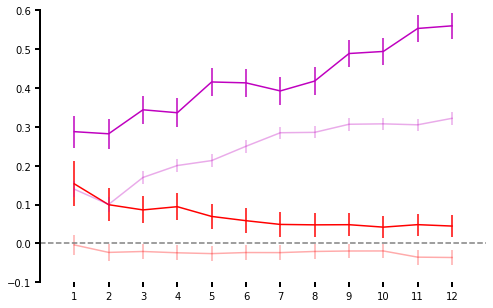

In [59]:
## # of PCs

plt.figure(figsize = [8,5])
## co-occurrence novelty within the valence novelty subspace (Supp Fig.4A)
# plt.errorbar(np.arange(12), np.mean(before_co_space_co, axis=1), np.std(before_co_space_co, axis=1), color = 'r', alpha = 0.33)
# plt.errorbar(np.arange(12), np.mean(after_co_space_co, axis=1), np.std(after_co_space_co, axis=1), color = 'r')
# plt.errorbar(np.arange(12), np.mean(before_co_space_val, axis=1), np.std(before_co_space_val, axis=1), color = 'm', alpha = 0.33)
# plt.errorbar(np.arange(12), np.mean(after_co_space_val, axis=1), np.std(after_co_space_val, axis=1), color = 'm')

## valence novelty within the co-occurrence novelty subspace (Supp Fig.4C)
plt.errorbar(np.arange(12), np.mean(before_val_space_co, axis=1), np.std(before_val_space_co, axis=1), color = 'r', alpha = 0.33)
plt.errorbar(np.arange(12), np.mean(after_val_space_co, axis=1), np.std(after_val_space_co, axis=1), color = 'r')
plt.errorbar(np.arange(12), np.mean(before_val_space_val, axis=1), np.std(before_val_space_val, axis=1), color = 'm', alpha = 0.33)
plt.errorbar(np.arange(12), np.mean(after_val_space_val, axis=1), np.std(after_val_space_val, axis=1), color = 'm')

plt.xticks(np.arange(12),np.arange(1,13))
plt.xlim([-1,12])    
plt.ylim([-0.1,0.6])
plt.hlines(0,-1,20, color = 'grey', linestyle = '--')

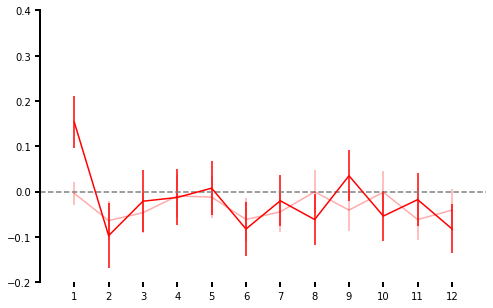

In [43]:
## each PC

plt.figure(figsize = [8,5])
## co-occurrence novelty within the valence novelty subspace (Supp Fig.4B)
plt.errorbar(np.arange(12), np.mean(before_val_space_co, axis=1), np.std(before_val_space_co, axis=1), color = 'r', alpha = 0.33)
plt.errorbar(np.arange(12), np.mean(after_val_space_co, axis=1), np.std(after_val_space_co, axis=1), color = 'r')

## valence novelty within the co-occurrence novelty subspace (Supp Fig.4D)
# plt.errorbar(np.arange(12), np.mean(before_co_space_val, axis=1), np.std(before_co_space_val, axis=1), color = 'm', alpha = 0.33)
# plt.errorbar(np.arange(12), np.mean(after_co_space_val, axis=1), np.std(after_co_space_val, axis=1), color = 'm')

plt.xticks(np.arange(12),np.arange(1,13))
plt.xlim([-1,12])    
plt.ylim([-0.2,0.4])
# plt.ylim([-0.1,0.6])
plt.hlines(0,-1,20, color = 'grey', linestyle = '--')

### Coordinated memory computation

#### Each time plot (Fig. 5C)

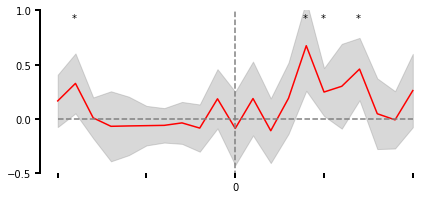

In [63]:
## co-occurrence novelty within the memorability subspace 
fMRI_data_true = memory_space_novelty_true[roi_num]
fMRI_data_perm = memory_space_novelty_perm[roi_num]

pc_num = [1] # shared coding axis within the memorability subspace
model_data = [-1,-1,-1,0,0,0,1,1,1] # co-occurrence novelty
r2_true, r2_perm, pvalue = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                         perm_data = fMRI_data_perm, 
                                                         pc_num = pc_num,
                                                         model_data = model_data)

fig = plt.figure(figsize = [7,3])
axs = fig.add_subplot()

axs.plot(r2_true-np.mean(r2_perm, axis=0), 'r')
errorh = np.array([np.std(r2_true[t] - r2_perm[:,t])*2 for t in range(window_length)])
axs.fill_between(np.arange(window_length), r2_true-np.mean(r2_perm, axis=0)-errorh,r2_true-np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')

axs.set_ylim([-0.5,1])
axs.hlines(0, 0, window_length-1, linestyle = '--', color = 'grey')
axs.vlines(10, -1, 1, linestyle = '--', color = 'grey')
axs.set_xticks([0,5,10,15,20])
axs.set_yticks([-0.5,0,0.5,1])
axs.set_xticklabels(['','',0,'',''])

for t in range(21):
    if np.sum(r2_perm[:,t] > r2_true[t])/repetition < .05:
        plt.text(t-0.2,0.9,'*')

#### Average across 10 TRs (Supp Fig. 7)

In [64]:
fMRI_data_true = memory_space_novelty_true[roi_num]
fMRI_data_perm = memory_space_novelty_perm[roi_num]
pc_num = [1]
model_data = [-1,-1,-1,0,0,0,1,1,1] # co-occurrence novelty
r2_true_cooccur, r2_perm_cooccur, pvalue_cooccur = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                                                 perm_data = fMRI_data_perm, 
                                                                                 pc_num = pc_num, 
                                                                                 model_data = model_data)

pc_num = [1]
model_data = [-1,0,1,-1,0,1,-1,0,1] # valence novelty
r2_true_valence, r2_perm_valence, pvalue_valence = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                                                 perm_data = fMRI_data_perm, 
                                                                                 pc_num = pc_num, 
                                                                                 model_data = model_data)

In [ ]:
Memory_space_cooccur_before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
Memory_space_cooccur_after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T

Memory_space_valence_before = np.mean(r2_true[:10]) - np.mean(r2_perm[:,:10], axis=1).T
Memory_space_valence_after = np.mean(r2_true[11:]) - np.mean(r2_perm[:,11:], axis=1).T

(-0.3, 0.6)

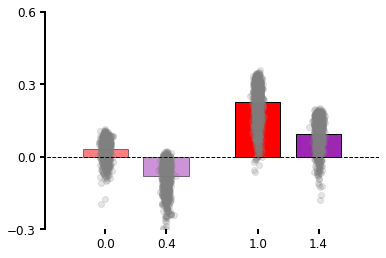

In [76]:
corr_look = np.array([np.mean(r2_true_cooccur[:10]), np.mean(r2_true_valence[:10]),  
                      np.mean(r2_true_cooccur[11:]), np.mean(r2_true_valence[11:])])
random_look = np.array([np.mean(r2_perm_cooccur[:,:10], axis=1).T, np.mean(r2_perm_valence[:,11:], axis=1).T,
                        np.mean(r2_perm_cooccur[:,11:], axis=1).T, np.mean(r2_perm_valence[:,11:], axis=1).T])
diff = np.array([corr_look]).T - random_look

x_pos = [0,0.4,1,1.4]
plt.figure(figsize = [6,4])
plt.xticks(x_pos, fontsize = 12)
plt.yticks([-0.3,0,0.3,0.6], fontsize = 12)
plt.xlim([-0.4,1.8])
plt.hlines([0],-1,5, 'black', linewidth = 1, linestyle = '--')

barlist = plt.bar(x_pos, np.mean(diff, axis=1), width = 0.3, edgecolor = 'k', alpha = 1)
barlist[0].set_facecolor('#FF0000')
barlist[0].set_alpha(0.5)
barlist[1].set_facecolor('#9C27B0')
barlist[1].set_alpha(0.5)
barlist[2].set_facecolor('#FF0000')
barlist[3].set_facecolor('#9C27B0')
# plt.errorbar(x_pos, np.mean(diff, axis=1), np.std(diff, axis=1), linestyle = '', color = 'k')

for c in range(4):
    plt.scatter(np.random.normal(size=1000)/70 + x_pos[c], diff[c], color = 'gray', alpha = 0.2)

plt.ylim([-0.3, 0.6])

#### Inveserly alignment of hippocampal states (Fig. 5D)

In [81]:
true1 = []
perm1 = []
true2 = []
perm2 = []
true3 = []
perm3 = []
for t in range(21):
    true_comem = spearmanr(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t])[0] # memorability pos -> neg / novelty neg -> pos
    true_valmem = spearmanr(memory_space_memory_true[0][:,1,t], novelty_val_space_novelty_true[0][:,0,t])[0]
    perm_comem = np.array([spearmanr(memory_space_memory_perm[0][r][:,1,t], novelty_co_space_novelty_perm[0][r][:,0,t])[0] for r in range(1000)])
    perm_valmem = np.array([spearmanr(memory_space_memory_perm[0][r][:,1,t], novelty_val_space_novelty_perm[0][r][:,0,t])[0] for r in range(1000)])
    true1.append(true_comem)
    perm1.append(perm_comem)
    true2.append(true_valmem)
    perm2.append(perm_valmem)
    true3.append(true_comem + true_valmem)
    perm3.append(perm_comem + perm_valmem)
true1 = np.array(true1)
perm1 = np.array(perm1)
true2 = np.array(true2)
perm2 = np.array(perm2)
true3 = np.array(true3)
perm3 = np.array(perm3)
print([np.sum(true1[t] < perm1[t])/1000 for t in range(21)])
print([np.sum(true2[t] < perm2[t])/1000 for t in range(21)])
print([np.sum(true3[t] < perm3[t])/1000 for t in range(21)])

[0.258, 0.071, 0.374, 0.508, 0.46, 0.534, 0.971, 0.525, 0.254, 0.422, 0.978, 0.658, 0.457, 0.062, 0.01, 0.076, 0.117, 0.235, 0.365, 0.973, 0.605]
[0.707, 0.454, 0.545, 0.354, 0.234, 0.188, 0.979, 0.768, 0.788, 0.661, 0.985, 0.845, 0.309, 0.024, 0.087, 0.213, 0.204, 0.518, 0.382, 0.88, 0.737]
[0.5, 0.09, 0.451, 0.354, 0.21, 0.2, 0.991, 0.777, 0.611, 0.66, 0.995, 0.892, 0.278, 0.014, 0.008, 0.057, 0.065, 0.259, 0.279, 0.974, 0.819]


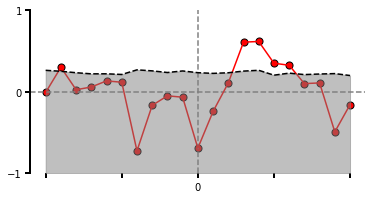

In [78]:
## Both novelties

plt.figure(figsize = [6,3])
true = true3/2
# true_co = np.array([cos_sim(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t]) for t in range(window_length)])
# true_co = np.array([spearmanr(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t])[0] for t in range(window_length)])
error = np.std(perm3/2, axis=1)
plt.scatter(np.arange(21), true, s = 50, color = 'red', edgecolor = 'k', zorder = 1)
plt.plot(true,'red',zorder=2)
plt.fill_between(np.arange(21), -1, +error, alpha = 0.5,color = 'grey',zorder=2)
plt.plot(error,'k--',zorder=2)

plt.xlim([-1,21])
plt.ylim([-1,1])
plt.xticks([0,5,10,15,20],['','',0,'',''])
plt.yticks([-1,0,1])    
plt.vlines(10,-1,1,'grey','--',zorder=1)
plt.hlines(0,-1,21,'grey','--',zorder=1)

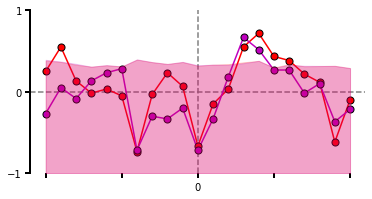

In [83]:
## Each novelty

plt.figure(figsize = [6,3])
# true_co = np.array([cos_sim(zscore(memory_space_memory_true[0][:,1,t]), zscore(novelty_co_space_novelty_true[0][:,0,t])) for t in range(window_length)])
# true_co = np.array([cos_sim(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t]) for t in range(window_length)])
true_co = np.array([spearmanr(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t])[0] for t in range(window_length)])
error_co = np.array([np.std(perm1[t]) for t in range(window_length)])
plt.scatter(np.arange(21), true_co, s = 50, color = 'r', edgecolor = 'k', zorder = 3)
plt.plot(true_co,'r',zorder=2)
plt.fill_between(np.arange(window_length), -1, +error_co, alpha = 0.2,color = 'r',zorder=4)

# true_val = np.array([cos_sim(zscore(memory_space_memory_true[0][:,1,t]), zscore(novelty_val_space_novelty_true[0][:,0,t])) for t in range(window_length)])
# true_val = np.array([cos_sim(memory_space_memory_true[0][:,1,t], novelty_val_space_novelty_true[0][:,0,t]) for t in range(window_length)])
true_val = np.array([spearmanr(memory_space_memory_true[0][:,1,t], novelty_val_space_novelty_true[0][:,0,t])[0] for t in range(window_length)])
error_val = np.array([np.std(perm2[t]) for t in range(window_length)])
plt.scatter(np.arange(21), true_val, s = 50, color = 'm', edgecolor = 'k', zorder = 3)
plt.plot(true_val,'m',zorder=2)
plt.fill_between(np.arange(window_length), -1, +error_val, alpha = 0.2,color = 'm',zorder=4)

plt.xlim([-1,21])
plt.ylim([-1,1])
plt.xticks([0,5,10,15,20],['','',0,'',''])
plt.yticks([-1,0,1])    
plt.vlines(10,-1,1,'grey','--',zorder=1)
plt.hlines(0,-1,21,'grey','--',zorder=1)

#### Hippocampal states along the shared coding axis

([], [])

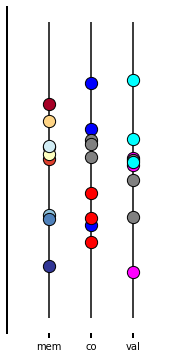

In [86]:
timepoint = 10 + 4

fig = plt.figure(figsize = [3,6])
fig.gca().set_prop_cycle(plt.cycler('color', plt.cm.RdYlBu(np.linspace(0, 1, 9))))
for p in range(9):
    plt.scatter([0],zscore(memory_space_memory_true[0][:,1,timepoint])[p],zorder=2,s=150,edgecolor='k')
plt.vlines(0,-3,3,'k',zorder=1)
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Cooccur_vs_valence_v3/a1.png', dpi=300, bbox_inches = "tight")

colors = [[0,0,1],[0,0,1],[0,0,1],
          [0.5,0.5,0.5],[0.5,0.5,0.5],[0.5,0.5,0.5],
          [1,0,0],[1,0,0],[1,0,0]]
for p in range(9):
    plt.scatter([0.5], zscore(novelty_co_space_novelty_true[0][:,0,timepoint])[p], color = colors[p], zorder=2,s=150,edgecolor='k')
plt.vlines(0.5,-3,3,'k',zorder=1)

colors = [[1,0,1],[0.5,0.5,0.5],[0,1,1],
          [1,0,1],[0.5,0.5,0.5],[0,1,1],
          [1,0,1],[0.5,0.5,0.5],[0,1,1]]
for p in range(9):
    plt.scatter([1], zscore(novelty_val_space_novelty_true[0][:,0,timepoint])[p], color = colors[p], zorder=2,s=150,edgecolor='k')
plt.vlines(1,-3,3,'k',zorder=1)
plt.xlim([-0.5,1.5])
plt.xticks([0,0.5,1],['mem','co','val'])
plt.yticks([])

### Dynamics of memory retrieval process (Fig. 6B)

In [ ]:
## memorability within the memory retrieval subspace 
fMRI_data_true = recall_start_space_recall_true[roi_num]
fMRI_data_perm = recall_start_space_recall_perm[roi_num]

pc_num = [0] # memorability coding axis within the memory retrieval subspace
model_data = [-4,-3,-2,-1,0,1,2,3,4] # memorability
r2_true, r2_perm, pvalue = subspace_encoding_performance(true_data = fMRI_data_true, 
                                                         perm_data = fMRI_data_perm, 
                                                         pc_num = pc_num,
                                                         model_data = model_data)

fig = plt.figure(figsize = [7,3])
axs = fig.add_subplot()

axs.plot(r2_true-np.mean(r2_perm, axis=0), 'r')
errorh = np.array([np.std(r2_true[t] - r2_perm[:,t])*2 for t in range(window_length)])
axs.fill_between(np.arange(window_length), r2_true-np.mean(r2_perm, axis=0)-errorh,r2_true-np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')

axs.set_ylim([-0.5,1])
axs.hlines(0, 0, window_length-1, linestyle = '--', color = 'grey')
axs.vlines(10, -1, 1, linestyle = '--', color = 'grey')
axs.set_xticks([0,5,10,15,20])
axs.set_yticks([-0.5,0,0.5,1])
axs.set_xticklabels(['','',0,'',''])

for t in range(21):
    if np.sum(r2_perm[:,t] > r2_true[t])/100 < .05:
        plt.text(t-0.2,0.9,'*')